In [111]:
#import packages
import torch
import torch.nn as nn
import numpy as np

In [112]:
#Define generation functions
def sin(x):
    y = np.sin(x)
    return y

def advanced_sin(x, mode_num):
    y = np.sin(x)
    for i in range(mode_num):
        y += np.sin((i+2)*x)
    return y

#Regular mix function creates a serie which alters every 20 time steps between sin and cos
#add_x is the signal list to record down the function at current time step (1 for sin, -1 for cos)
def regular_mix(x, time_steps):
    add_x = []
    y = []
    for i in range(time_steps):
        if (i // 20) % 2 == 0:
            y.append(np.sin(x[i]))
            add_x.append(1)
        else:
            y.append(np.cos(x[i]))
            add_x.append(-1)
    y = np.array(y)
    add_x = np.array(add_x)
    return y, add_x

#Random mix function creates a serie which alters randomly every [shift_range] time steps between sin and cos 
def random_mix(x, time_steps, shift_range):
    random_array = np.random.randint(2, size=2000)
    add_x = []
    y = []
    flag = None
    for i in range(time_steps):
        if i % shift_range == 0:
            if random_array[i] == 1:
                flag = 'sin'
                y.append(np.sin(x[i]))
                add_x.append(1)
            else:
                flag = 'cos'
                y.append(np.cos(x[i]))
                add_x.append(-1)
        else:
            if flag == 'sin':
                y.append(np.sin(x[i]))
                add_x.append(1)
            else:
                y.append(np.cos(x[i]))
                add_x.append(-1)
    y = np.array(y)
    add_x = np.array(add_x)
    return y, add_x

In [114]:
#Generate different data series
#Choose the mode in sin, advanced sin, regular mix, random mix
mode = 'random mix'
time_steps_per_period = 200
period = 10
time_steps = time_steps_per_period * period
x = np.linspace(0, 2 * period * np.pi, time_steps)
x_test = np.linspace(2 * period * np.pi, 2 * (period+1) * np.pi, time_steps_per_period)

if mode == 'sin':
    y = sin(x)
    y_test = sin(x_test)
elif mode == 'advanced sin':
    # how many numbers of different frequency sin functions you want to add together 
    mode_num = 5
    y = advanced_sin(x, mode_num)
    y_test = advanced_sin(x_test, mode_num)
elif mode == 'regular mix':
    y, add_x = regular_mix(x, time_steps)
    y_test, add_x_test = regular_mix(x_test, time_steps_per_period)
elif mode == 'random mix':
    # how frequent (judge every shift_range numbers) you want the data to have a chance to shift from sin to cos or cos to sin
    shift_range = 10
    y, add_x = random_mix(x, time_steps, shift_range)
    y_test, add_x_test = random_mix(x_test, time_steps_per_period, shift_range)

In [115]:
#Generate training data
#Deductive flag: if you want to add the 11th digit as the indication of sin/cos
deductive_flag = True
if deductive_flag:
    X_input = np.zeros((time_steps-10,11))
else:
    X_input = np.zeros((time_steps-10,10))
Y_target = np.zeros((time_steps-10,1))
for i in range(time_steps-10):
    X_input[i,0:10] = y[i:i+10]
    if deductive_flag:
        X_input[i,-1] = add_x[i]
    Y_target[i] = y[i+10]
if deductive_flag:
    X_input_test = np.zeros((time_steps_per_period-10,11))
else:
    X_input_test = np.zeros((time_steps_per_period-10,10))
Y_target_test = np.zeros((time_steps_per_period-10,1))
for i in range(time_steps_per_period-10):
    X_input_test[i,0:10] = y_test[i:i+10]
    if deductive_flag:
        X_input_test[i,-1] = add_x_test[i]
    Y_target_test[i] = y_test[i+10]

In [116]:
#Define model architecture
input_seq = torch.Tensor(X_input)  # Input sequence (previous values)                                                                                                             
target_seq = torch.Tensor(Y_target)  # Target sequence (next values)                                                                                                              

# Define the Feedforward Neural Network model                                                                                                                                     
if deductive_flag:
    input_size = 11
else:
    input_size = 10
hidden_size = 16
output_size = 1

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    nn.Linear(hidden_size, output_size)                                                                                                                                                
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [117]:
#Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    outputs = model(input_seq)
    loss = criterion(outputs, target_seq)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [100/2000], Loss: 0.050289
Epoch [200/2000], Loss: 0.043681
Epoch [300/2000], Loss: 0.042784
Epoch [400/2000], Loss: 0.042287
Epoch [500/2000], Loss: 0.042037
Epoch [600/2000], Loss: 0.041824
Epoch [700/2000], Loss: 0.041691
Epoch [800/2000], Loss: 0.041581
Epoch [900/2000], Loss: 0.041500
Epoch [1000/2000], Loss: 0.041430
Epoch [1100/2000], Loss: 0.041358
Epoch [1200/2000], Loss: 0.041304
Epoch [1300/2000], Loss: 0.041258
Epoch [1400/2000], Loss: 0.041211
Epoch [1500/2000], Loss: 0.041168
Epoch [1600/2000], Loss: 0.041132
Epoch [1700/2000], Loss: 0.041100
Epoch [1800/2000], Loss: 0.041043
Epoch [1900/2000], Loss: 0.041025
Epoch [2000/2000], Loss: 0.041003


In [118]:
#Print test set mean squared error
model.eval()
output_test = model(torch.Tensor(X_input_test))
output_test = output_test.detach().numpy()
mse = ((output_test - Y_target_test)**2).mean()
print(mse)

0.07460899914213943


(190, 1)


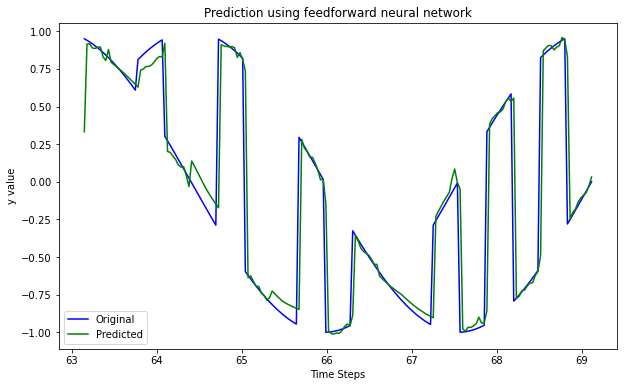

In [119]:
#Plot the results
import matplotlib.pyplot as plt
print(Y_target_test.shape)
plt.figure(figsize=(10, 6))                                    
plt.title('Prediction using feedforward neural network')                                                                                                                
plt.xlabel('Time Steps')                                                                                                                                                          
plt.ylabel('y value')                                                                                                                                                             
plt.plot(x_test[10:], np.reshape(Y_target_test,(190,)), label='Original', color='blue')                                                                                                                            
plt.plot(x_test[10:], np.reshape(output_test,(190,)), label='Predicted', color ='green')                                                                                                                                                                                                                    
plt.legend()                                                                                                                                                                      
plt.show()